# Introduction

In this Data Cleaning Walkthrough we'll be working with SAT test data from NY Schools. We will be investigating correlations between SAT scores and demographics, as well as factors like race, gender, income, and more.

New York City makes its data on high school SAT scores available [online](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4), as well as the [demographics](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2) for each high school.


## The Data

#### From our background research we can state the following:

 - Only high school students take the SAT, so we'll want to focus on high schools.
 - New York City is made up of five boroughs, which are essentially distinct regions.
 - New York City schools fall within several different school districts, each of which can contains dozens of schools.
 - Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
 - Each school in New York City has a unique code called a DBN, or district borough number.
 - Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

#### The following files have been stored in the `schools` folder:


 - `ap_2010.csv` - Data on AP test results
 - `class_size.csv` - Data on class size
 - `demographics.csv` - Data on demographics
 - `graduation.csv` - Data on graduation outcomes
 - `hs_directory.csv` - A directory of high schools
 - `sat_results.csv` - Data on SAT scores
 
 - `survey_all.txt` - Data on surveys from all schools
 - `survey_d75.txt` - Data on surveys from New York City district 75
 
We'll start by importing necessary modules and the CSV files. We'll read each of these CSV files into a pandas dataframe, and then store all of the dataframes in a dictionary. This will give us a convenient way to store them, and a quick way to reference them later on.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf 
# import geopandas
import re

# This will need to be done in the future so 
# get accustomed to using now
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
 



data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    key_name = f.replace(".csv", "")
    data[key_name] = d

## Explore the SAT data

We're mainly interested in the SAT test results, so we'll start exploring there:

print(data["sat_results"].head())

### Observations:

We can make a few observations based on this output:

 - The `DBN` is a unique ID for each school.
 - We can tell from the first few rows of names that we only have data about high schools.
 - There's only a single row for each high school, so each `DBN` is unique in the SAT data.
 - We may eventually want to combine the three columns that contain `SAT scores` -- `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.

In [10]:
for key in data: 
    print(data[key].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

### Observations: 

 - As `DBN` is an ID for each school, we can use that column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical `DBN`s, then group all of their columns together in a single data set.
 - Some fields look interesting for mapping -- particularly `Location 1`, which contains coordinates inside a larger string.
 - Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate `DBN` values). That means we’ll have to do some preprocessing to ensure that each `DBN` is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

## More Data

We'll now concentrate on reading in the survey data (`survey_all.txt` and `survey_d75.txt`). These are tab delimited with `Windows-1252` encoding which we'll need to specify. 

After we read in the file we will combine it with the pandas `concat` method: `z = pd.concat([x,y], axis=0)`

In [11]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter="\t", encoding="windows-1252")

d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter="\t", encoding="windows-1252")

# z = pd.concat([x,y], axis=0)
survey = pd.concat([all_survey, d75_survey], axis=0)

/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Observations 

There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
The survey data has a `dbn` column that we'll want to convert to uppercase (`DBN`). The conversion will make the column name consistent with the other data sets.

To filter the columns to remove the ones we don't need, we'll use the [available data dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.

In [12]:
survey["DBN"] = survey["dbn"]

relevant_columns = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11"
]

survey = survey.loc[:, relevant_columns]
data["survey"] = survey

print(survey.head())

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

   ...  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0  ...       7.6       7.9       NaN       NaN       NaN       NaN   
1  ...       8.9       9.1       NaN       NaN       NaN       NaN   
2  ...       6.8       7.5       NaN       NaN       NaN       NaN   
3  ...       6.8       7.8       6.2       5.9       6.5       7.4   
4  ...       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  
0         8.0         7.7         7.5   

In [13]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Data columns (total 23 columns):
DBN           1702 non-null object
rr_s          1041 non-null float64
rr_t          1702 non-null int64
rr_p          1702 non-null int64
N_s           1036 non-null float64
N_t           1700 non-null float64
N_p           1696 non-null float64
saf_p_11      1696 non-null float64
com_p_11      1696 non-null float64
eng_p_11      1696 non-null float64
aca_p_11      1696 non-null float64
saf_t_11      1700 non-null float64
com_t_11      1700 non-null float64
eng_t_11      1700 non-null float64
aca_t_11      1700 non-null float64
saf_s_11      1036 non-null float64
com_s_11      1036 non-null float64
eng_s_11      1036 non-null float64
aca_s_11      1036 non-null float64
saf_tot_11    1702 non-null float64
com_tot_11    1702 non-null float64
eng_tot_11    1702 non-null float64
aca_tot_11    1702 non-null float64
dtypes: float64(20), int64(2), object(1)
memory usage: 319.1+ KB


### Inserting DBN fields

When we explored all of the data sets, we noticed that some of them, like `class_size` and `hs_directory`, don't have a `DBN` column. `hs_directory` does have a `dbn` column, though, so we can just rename it.

However, `class_size` doesn't appear to have the column at all. Here are the first few rows of the data set:

In [14]:
print(data['class_size'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


#### DBN form

The `DBN` in the `sat_results` data is a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data. The main difference is that the `DBN` is padded, so that the `CSD` portion of it always consists of two digits. That means we'll need to add a leading 0 to the `CSD` if the `CSD` is less than two digits long. 

#### Strategy

We can accomplish this using the `pandas.Series.apply()` method, along with a custom function that:

 - Takes in a number.
 - Converts the number to a string using the `str()` function.
 - Check the length of the string using the `len()` function.
 - If the string is two digits long, returns the string.
 - If the string is one digit long, adds a 0 to the front of the string, then returns it.
 - Use the string method `zfill()` to do this.

In [15]:
# Copy the dbn column in hs_directory into a new column called DBN
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# custom function which accepts a number, returns a padded string
def pad_csd(num):
    return str(num).zfill(2)

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
print(data['class_size']['DBN'].head())

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object


## Combine SAT data and test scores


In [16]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


## Parsing Geographic Coordinates for Schools

Next, we'll want to parse the `latitude` and `longitude` coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` data set:

In [17]:
print(data['hs_directory']['Location 1'].head())

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object


As you can see, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field.

In [18]:
# Function to extract the latitude
def find_lat(loc):
    
    #re to pull out the coordinates inside the parentheses
    coords = re.findall("\(.+\)", loc)
    
    # Uses string manipulation functions to pull out the latitude
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Use the Series.apply() method to apply the function across the Location 1 column of hs_directory
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)

print(data['hs_directory']['lat'].head())

0     40.67029890700047
1      40.8276026690005
2    40.842414068000494
3     40.71067947100045
4    40.718810094000446
Name: lat, dtype: object


In [19]:
# Function to extract the longitude
def find_lon(loc):
    
    #re to pull out the coordinates inside the parentheses
    coords = re.findall("\(.+\)", loc)
    
    # Uses string manipulation functions to pull out the longitute
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Use the Series.apply() method to apply the function across the Location 1 column of hs_directory
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Use the to_numeric() function to convert the lat and lon columns of hs_directory to numbers.
# Specify the errors="coerce" keyword argument to handle missing values properly.

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

print(data['hs_directory']['lon'].head())

0   -73.961648
1   -73.904475
2   -73.916162
3   -74.000807
4   -73.806500
Name: lon, dtype: float64


## Condensing Data

Condensing the Class Size Data Set

The first data set that we'll condense is `class_size`, which looks like this: 

In [20]:
print(data['class_size'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


In [21]:
# class_size.info()
#class_size['GRADE'].unique()
class_size['GRADE '].unique()

NameError: name 'class_size' is not defined

In [ ]:
class_size['PROGRAM TYPE'].unique()

### Observations

We can see that the first few rows all pertain to the same school, which is why the `DBN` appears more than once. Each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`. 

We'll filter out data where `GRADE` is `09-12`, since that is high school. 

Each school can have multiple program types. We'll select the largest `PROGRAM TYPE` which is `GEN ED`.

 - df.name.unique()

In [22]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

In [23]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

###  Condensing & Data Aggregation - `pd.DataFrame.groupby()`
#### Computing Average Class Size

This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique `DBN` values, while also incorporating as much data as possible into the average.

Fortunately, we can use the `pandas.DataFrame.groupby()` method to help us with this. The `DataFrame.groupby()` method will split a dataframe up into unique groups, based on a given column. We can then use the `agg()` method on the resulting `pandas.core.groupby` object to find the mean of each column.

In [24]:
# Find the average values for each column associated with each DBN in class_size

# Use the pandas.DataFrame.groupby() method to group class_size by DBN
# Use the agg() method on the resulting pandas.core.groupby object, 
# with the numpy.mean() function as an argument, to calculate the average of each group.
class_size = class_size.groupby("DBN").agg(np.mean)

# Reset the index to make DBN a column again.
# Use the pandas.DataFrame.reset_index() method, keyword argument inplace=True.
class_size.reset_index(inplace=True)

#Assign class_size back to the class_size key of the data dictionary
data["class_size"] = class_size
print(data["class_size"].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

### Condense `demographics`

Now that we've finished condensing `class_size`, let's condense `demographics`. The first few rows look like this:

In [25]:
print(data['demographics'].head())

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2  ... black_num black_per  \
0               281   15  36     40     33  ...        74      26.3   
1               243   15  29     39     38  ...        68      28.0   
2               261   18  43     39     36  ...        77      29.5   
3               252   17  37     44     32  ...        75      29.8   
4               208   16  40     28     32  ...        67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \
0          189         67.3         

### Observations: 

In this case, the only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [26]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
print(data["demographics"].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

### Condense `graduation`

Finally, we'll need to condense the `graduation` data set. Here are the first few rows:

In [27]:
print(data['graduation'].head())

    Demographic     DBN                            School Name    Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2005   
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2006   
4  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL  2006 Aug   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
0             5               s                         s                 s   
1            55              37                     67.3%                17   
2            64              43                     67.2%                27   
3            78              43                     55.1%                36   
4            78              44                     56.4%                37   

  Total Regents - % of cohort Total Regents - % of grads  ...  \
0  

### Observations:

The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the graduation data. A `Cohort` refers to the year the data represents, and the `Demographic` refers to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [28]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
print(data["graduation"]["Total Cohort"].head())

3      78
10    124
17     90
24     84
31    193
Name: Total Cohort, dtype: int64


### Converting AP Test Scores

We're almost ready to combine all of the data sets. The only remaining thing to do is convert the Advanced Placement (`AP`) test scores from strings to numeric values.

It's of interest to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the `ap_2010` data set to numeric values first.

There are three columns we'll need to convert:

 - `AP Test Takers ` (note that there's a trailing space in the column name)
 - `Total Exams Taken`
 - `Number of Exams with scores 3 4 or 5`
 
#### Steps: 
 - Convert each of the following columns in `ap_2010` to numeric values using the `pandas.to_numeric()` function with the keyword argument `errors="coerce"`.
   - `AP Test Takers `
   - `Total Exams Taken`
   - `Number of Exams with scores 3 4 or 5`
- Display the column types using the `dtypes` attribute.

In [29]:
data["ap_2010"]["AP Test Takers "] = pd.to_numeric(data["ap_2010"]
                                                   ["AP Test Takers "], 
                                                   errors="coerce")
data["ap_2010"]["Total Exams Taken"] = pd.to_numeric(data["ap_2010"]
                                                     ["Total Exams Taken"], 
                                                     errors="coerce")
data["ap_2010"]["Number of Exams with scores 3 4 or 5"] = pd.to_numeric(data["ap_2010"]
                                                                        ["Number of Exams with scores 3 4 or 5"], 
                                                                        errors="coerce")
print(data["ap_2010"].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


## Merging Data -  Left, Right, Inner, and Outer Joins

Before we merge our data, we'll need to decide on the merge strategy we want to use. We'll be using the `pandas.DataFrame.merge()` function, which supports four types of joins -- `left`, `right`, `inner`, and `outer`. Each of these join types dictates how pandas combines the rows.

We'll be using the `DBN` column to identify matching rows across data sets. In other words, the values in that column will help us know which row from the first data set to combine with which row in the second data set.

There may be `DBN` values that exist in one data set but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered. Human error (and other types of errors) may also play a role. Therefore, we may not find matches for the `DBN` values in `sat_results` in all of the other data sets, and other data sets may have `DBN` values that don't exist in `sat_results`.

We'll merge two data sets at a time. For example, we'll merge `sat_results` and `hs_directory`, then merge the result with `ap_2010`, then merge the result of that with `class_size`. We'll continue combining data sets in this way until we've merged all of them. Afterwards, we'll have roughly the same number of rows, but each row will have columns from all of the data sets.

The merge strategy we pick will affect the number of rows we end up with.

Because this project is concerned with determing demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

This means that we may need to use different merge strategies with different data sets. Some of the data sets have a lot of missing `DBN` values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge. If we did an inner join, we would lose the data for many high schools.

Some data sets have `DBN` values that are almost identical to those in `sat_results`. Those data sets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from demographics, for example. Therefore, we'll do an inner join to avoid missing data in these columns.

In [30]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")
print(combined.head(5))
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

### Inner Joins 

Now that we've performed the left joins, we still have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Because these files contain information that's more valuable to our analysis and also have fewer missing `DBN` values, we'll use the inner join type.

In [31]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

print(combined.head(5))
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

### Observations:

We noticed that the inner joins resulted in 116 fewer rows in `sat_results`. This is because pandas couldn't find the `DBN` values that existed in `sat_results` in the other data sets. While this is worth investigating, we're currently looking for high-level correlations, so we don't need to dive into which `DBN`s are missing.

You may also have noticed that we now have many columns with `NaN` values. This is because we chose to do left joins, where some columns may not have had data. The data set also had some missing values to begin with. If we hadn't performed a left join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our data set.

There are several ways to handle missing data, and we'll cover them in more detail later on. For now, we'll just fill in the missing values with the overall `mean` for the column.

We can fill in missing data in pandas using the `pandas.DataFrame.fillna()` method. This method will replace any missing values in a dataframe with the values we specify. We can compute the mean of every column using the `pandas.DataFrame.mean()` method. If we pass the results of the `df.mean()` method into the `df.fillna()` method, pandas will fill in the missing values in each column with the mean of that column.

Example: 
`means = df.mean()`
`df = df.fillna(means)`

Note that if a column consists entirely of `NaN` values, pandas won't be able to fill in the missing values when we use the `df.fillna()` method along with the `df.mean()` method, because there won't be a mean.

We should fill any `NaN` values that remain after the initial replacement with the value `0`. We can do this by passing `0` into the `df.fillna()` method.


 ## Filling in Missing Values
 
 Steps: 
 
 - Calculate the means of all of the columns in combined using the `pd.DataFrame.mean()` method.
 - Fill in any missing values in combined with the means of the respective columns using the `pd.DataFrame.fillna()` method.
 - Fill in any remaining missing values in combined with `0` using the `df.fillna()` method.
 - Display the first few rows of combined to verify that the correct operations occurred.

In [32]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

print(combined.head(5))

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

## Next Steps

We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

### Add a school district column for mapping

The school district is just the first two characters of the `DBN`. We can apply a function over the `DBN` column of combined that pulls out the first two letters.

In [33]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
print(combined["school_dist"].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


## Finding Correlation with the r values

The first thing we'll do is find any correlations between any of the columns and `sat_score`. This will help us determine which columns might be interesting to plot out or investigate further. Afterwards, we'll perform more analysis and make maps using the columns we've identified.

In [34]:
# Use the pandas.DataFrame.corr() method on the 
# combined dataframe to find all possible correlations
correlations = combined.corr()

# Filter for sat_score
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Observations:

Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`, and `sat_score` are strongly correlated with `sat_score`. 

 - `total_enrollment` has a strong positive correlation with `sat_score`. 
   - This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.

- Other columns that are proxies for enrollment correlate similarly. 
  - These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.


- Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. 
  - This could indicate that women do better on the SAT than men.


 - Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
 
 
 - Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).


 - There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).


 - The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.


 - Because enrollment seems to have such a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

We can plot columns in a dataframe using the `pandas.DataFrame.plot()` accessor on a dataframe. We can also specify a certain plot type. For example, `df.plot.scatter(x="A", y="b")` will create a scatterplot of columns `A` and `B`.

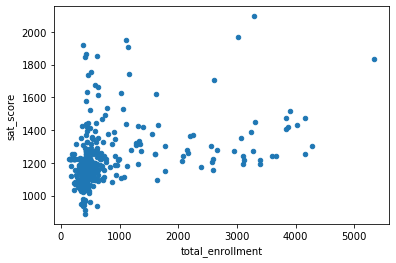

In [35]:
# scatterplot of total_enrollment versus sat_score.

combined.plot.scatter(x="total_enrollment", y="sat_score")

### Observations: 

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between `sat_score` and `total_enrollment`. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. This cluster may be what's making the `r value` so high. It's worth extracting the names of the schools in this cluster so we can research them further.

Steps:

 - Filter the combined dataframe to keep only those rows where total_enrollment is under 1000 and sat_score is under 1000. Assign the result to low_enrollment.
 - Display all of the items in the School Name column of low_enrollment.

In [36]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


### Plotting Language Learning 

We discovered that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`. To explore this relationship further, let's plot out `ell_percent` vs `sat_score` with a scatter plot.

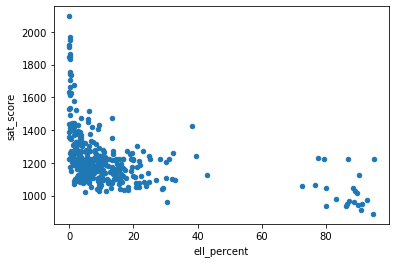

In [37]:
combined.plot.scatter(x='ell_percent', y='sat_score')
plt.show()

### Observations:

It looks like `ell_percent` correlates with `sat_score` more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high `ell_percent` values and low `sat_score` values. This cluster represents the same group of international high schools we investigated earlier.

In order to explore this relationship, we'll want to map out `ell_percent` by school district. The map will show us which areas of the city have a lot of English language learners.



In [38]:
'''
m = Basemap(
    projection='merc', 
    
    # latitude  of lower left hand corner of the desired map domain 
    llcrnrlat=40.496044, 
    
    # latitude of upper left hand corner of the desired map domain 
    urcrnrlat=40.915256, 
    
    # longitude of lower left hand corner of the desired map domain
    llcrnrlon=-74.255735, 
   
   # longitude of upper left hand corner of the desired map domain
    urcrnrlon=-73.700272,
    
    #resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
'''

"\nm = Basemap(\n    projection='merc', \n    \n    # latitude  of lower left hand corner of the desired map domain \n    llcrnrlat=40.496044, \n    \n    # latitude of upper left hand corner of the desired map domain \n    urcrnrlat=40.915256, \n    \n    # longitude of lower left hand corner of the desired map domain\n    llcrnrlon=-74.255735, \n   \n   # longitude of upper left hand corner of the desired map domain\n    urcrnrlon=-73.700272,\n    \n    #resolution='i'\n)\n\nm.drawmapboundary(fill_color='#85A6D9')\nm.drawcoastlines(color='#6D5F47', linewidth=.4)\nm.drawrivers(color='#6D5F47', linewidth=.4)\n"

![title](map_schools.png)

### Plotting out Statistics

In [39]:
'''

from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

'''

'\n\nfrom mpl_toolkits.basemap import Basemap\n\nm = Basemap(\n    projection=\'merc\', \n    llcrnrlat=40.496044, \n    urcrnrlat=40.915256, \n    llcrnrlon=-74.255735, \n    urcrnrlon=-73.700272,\n    resolution=\'i\'\n)\n\nm.drawmapboundary(fill_color=\'#85A6D9\')\nm.drawcoastlines(color=\'#6D5F47\', linewidth=.4)\nm.drawrivers(color=\'#6D5F47\', linewidth=.4)\n\nlongitudes = combined["lon"].tolist()\nlatitudes = combined["lat"].tolist()\nm.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")\nplt.show()\n\n'

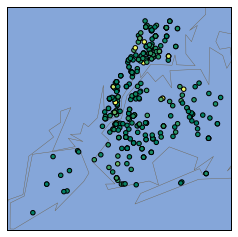

In [40]:
from IPython.display import Image
Image("stats.png")

In [42]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD  ...  \
0                            135.8000

### Plotting Percent Of English Learners by District

In [43]:
'''

from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
plt.show()

'''

'\n\nfrom mpl_toolkits.basemap import Basemap\n\nm = Basemap(\n    projection=\'merc\', \n    llcrnrlat=40.496044, \n    urcrnrlat=40.915256, \n    llcrnrlon=-74.255735, \n    urcrnrlon=-73.700272,\n    resolution=\'i\'\n)\n\nm.drawmapboundary(fill_color=\'#85A6D9\')\nm.drawcoastlines(color=\'#6D5F47\', linewidth=.4)\nm.drawrivers(color=\'#6D5F47\', linewidth=.4)\n\nlongitudes = districts["lon"].tolist()\nlatitudes = districts["lat"].tolist()\nm.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")\nplt.show()\n\n'

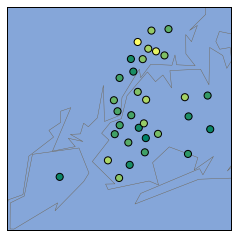

In [44]:
from IPython.display import Image
Image("ell.png")

### Plotting Survey Correlations

There are several fields in `combined` that originally came from a survey of `parents`, `teachers`, and `students`. We'll create a bar plot of the correlations between these fields and `sat_score`.

In [47]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
relevant_columns.remove("DBN")

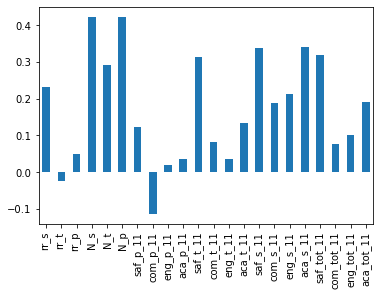

In [48]:
combined.corr()["sat_score"][relevant_columns].plot.bar()

### Findings:

 - There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

- It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

### Next Steps: Investigate safety scores.

We'll create a scatter plot of the `saf_s_11` column vs. the `sat_score` in `combined`.

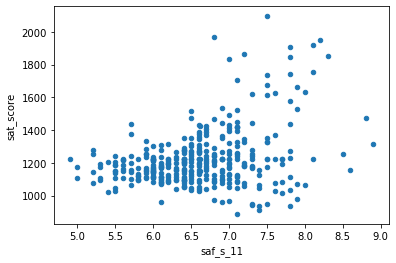

In [49]:
combined.plot.scatter("saf_s_11", "sat_score")

### Findings

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than aroun 1500.

Map out safety scores.
Compute the average safety score for each district.
Make a map that shows safety scores by district.
Write up your conclusions about safety by geographic area in a Markdown cell. 

In [50]:
'''

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you'll get an error. 
# We're working on a fix, thanks for your patience! This should work fine locally on your own computer though.
# m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()


'''

'\n\ndistricts = combined.groupby("school_dist").agg(numpy.mean)\ndistricts.reset_index(inplace=True)\n\nm = Basemap(\n    projection=\'merc\', \n    llcrnrlat=40.496044, \n    urcrnrlat=40.915256, \n    llcrnrlon=-74.255735, \n    urcrnrlon=-73.700272,\n    resolution=\'i\'\n)\n\nm.drawmapboundary(fill_color=\'#85A6D9\')\nm.drawcoastlines(color=\'#6D5F47\', linewidth=.4)\nm.drawrivers(color=\'#6D5F47\', linewidth=.4)\n# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you\'ll get an error. \n# We\'re working on a fix, thanks for your patience! This should work fine locally on your own computer though.\n# m.fillcontinents(color=\'white\',lake_color=\'#85A6D9\')\n\nlongitudes = districts["lon"].tolist()\nlatitudes = districts["lat"].tolist()\nm.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")\nplt.show()\n\n\n'

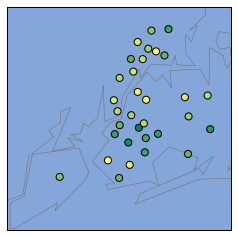

In [51]:
from IPython.display import Image
Image("safety.png")

In [52]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Racial differences in SAT scores

We'll now take a closer look at racial differences in SAT scores. We'll create a bar plot of the correlations between the columns above and `sat_score`.

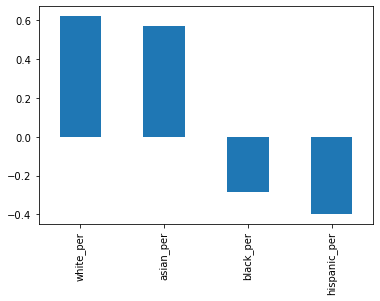

In [53]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

### Findings

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

We'll now explore schools with low SAT scores and high values for `hispanic_per`, by making a scatter plot of `hispanic_per` vs. `sat_score`.

combined.plot.scatter("hispanic_per", "sat_score")

We'll take a closer look at any schools with a `hispanic_per` greater than 95%.

In [56]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [57]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Findings 

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender differences in SAT scores

There are two columns that indicate the percentage of each gender at a school:

 - male_per
 - female_per

We can plot out the correlations between each percentage and `sat_score`.


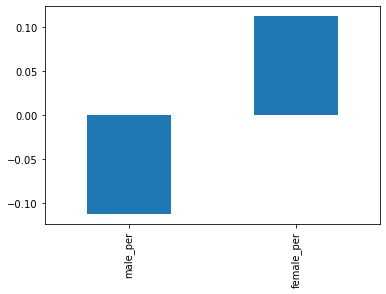

In [58]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

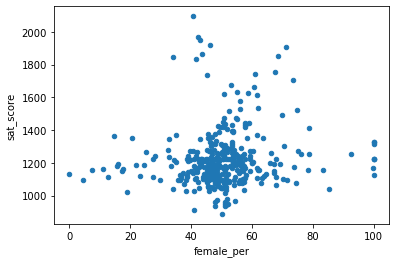

In [59]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [60]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

## Exploring AP Scores vs. SAT Scores

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

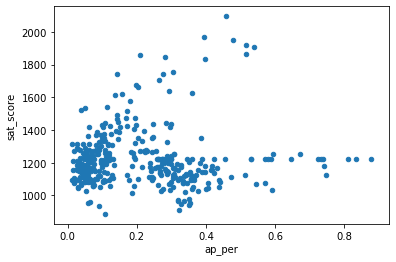

In [61]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.